# Customer Segmentation using K-Means clustering

# I. Module imports, data input and cleaning

In [1]:
# Import necessary modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from datetime import timedelta
import numpy as np
from numpy.linalg import norm
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples,silhouette_score
import matplotlib.cm as cm
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df = pd.read_excel("OnlineRetail.xlsx")

print(df.shape)
df.head(3)

(541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


<Axes: xlabel='Percent missing', ylabel='Feature'>

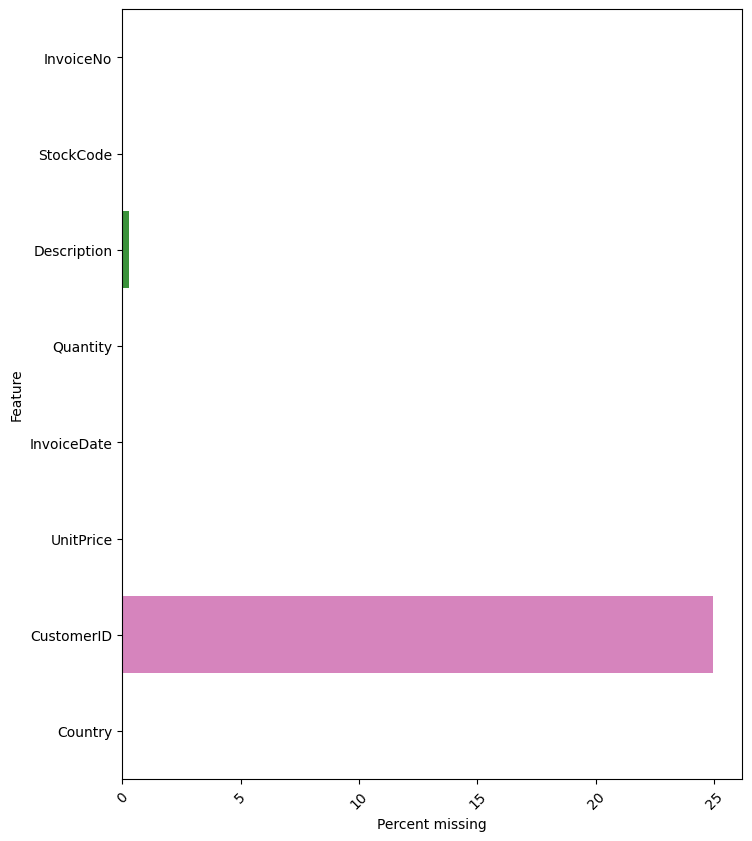

In [4]:
'''Calculate percentage null values for each column or feature'''
null_vals = df.isnull().sum()/len(df)*100
null_vals = pd.DataFrame(null_vals)
null_vals.reset_index(inplace = True)
null_vals.columns = ["Feature","Percent missing"]
plt.figure(figsize = (8,10))
plt.xticks(rotation=45)
sns.barplot(x = "Percent missing",y ="Feature",data = null_vals,orient = "h")

In [5]:
'''Drop rows with any null values'''

df1 = df.dropna(subset = ["CustomerID","Description"])
df1.shape

(406829, 8)

In [6]:
'''Drop duplicated rows'''

df2 = df1.drop_duplicates()
print(df2.shape)
df2.head(2)

(401604, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [7]:
'''We need only few columns from given dataset'''

df3 = df2 [['CustomerID','InvoiceDate','InvoiceNo','Quantity','UnitPrice']]
print(df3.shape)
df3.head(2)

(401604, 5)


,CustomerID,InvoiceDate,InvoiceNo,Quantity,UnitPrice
0,17850.0,2010-12-01 08:26:00,536365,6,2.55
1,17850.0,2010-12-01 08:26:00,536365,6,3.39


In [8]:
'''Create a total price column by multiplying quantity with unit price'''

df3['TotalPrice'] = df3['Quantity'] * df3['UnitPrice']
print(df3.shape)
df3.head(2)

(401604, 6)


,CustomerID,InvoiceDate,InvoiceNo,Quantity,UnitPrice,TotalPrice
0,17850.0,2010-12-01 08:26:00,536365,6,2.55,15.30
1,17850.0,2010-12-01 08:26:00,536365,6,3.39,20.34


In [9]:
#converting Invoice date into datetime object
df3['InvoiceDate'] = pd.to_datetime(df3['InvoiceDate'])  

In [10]:
'''Print out earliest and latest dates in the data'''
print('Transactions timeframe from {} to {}'.format(df3['InvoiceDate'].min(),df3['InvoiceDate'].max()))

Transactions timeframe from 2010-12-01 08:26:00 to 2011-12-09 12:50:00


In [11]:
# Create snapshot date
snapshot_date = df3['InvoiceDate'].max() + timedelta(days=1)
print(snapshot_date)

2011-12-10 12:50:00


###### Calculate the aggregates: recency, frequency and, monetary. Recency tells you how many days since last transaction for each customer, frequency tells you how frequently does a customer shop and, monetary tells you the total shopping spending for each customer'''

In [12]:
# Grouping by CustomerID
df4 = df3.groupby(['CustomerID']).agg({
        'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
        'InvoiceNo': 'count',
        'TotalPrice': 'sum'})
df4.rename(columns = {'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency','TotalPrice': 'Monetary'}, inplace=True)
print(df4.shape)
df4.head(3)

(4372, 3)


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,2,0.00
12347.0,2,182,4310.00
12348.0,75,31,1797.24


In [13]:
'''Remove rows with any zero values. This is to facilitate downstream pre-processing and avoid NaNs'''

df5 = df4[(df4 > 0).all(1)]
print(df5.shape)

(4322, 3)


# II. Data Pre-processing

In [14]:
'''The K-means clustering algorithm has a few key assumptions about the data: (1) data is not skewed, 
(2) features have the same mean and, (3) features have the same variance'''

df5.describe()

,Recency,Frequency,Monetary
count,4322.000000,4322.000000,4.322000e+03
mean,90.343591,92.850764,1.918498e+03
std,99.133565,230.357168,8.262490e+03
min,1.000000,1.000000,1.776357e-15
25%,17.000000,18.000000,3.005975e+02
50%,49.500000,42.000000,6.533250e+02
75%,138.000000,101.000000,1.624118e+03
max,374.000000,7812.000000,2.794890e+05


In [15]:
df5.head()

,Recency,Frequency,Monetary
CustomerID,,,
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,19,73,1757.55
12350.0,310,17,334.40
12352.0,36,95,1545.41


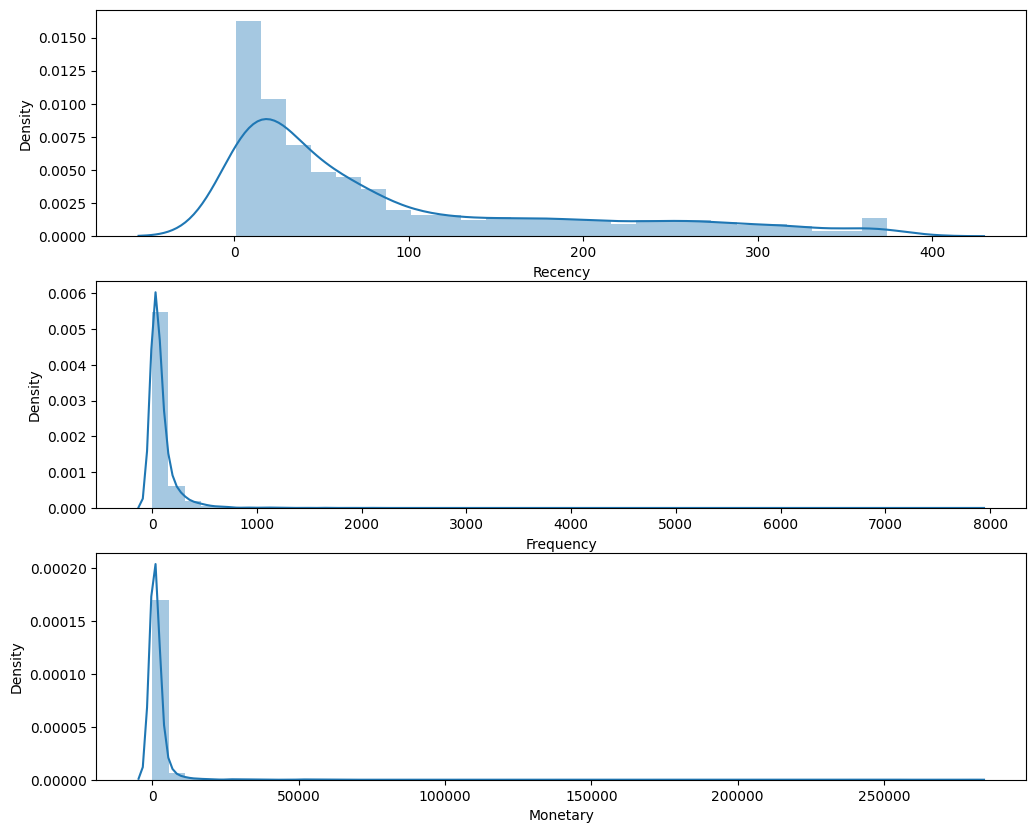

In [16]:
# Plot RFM distributions
plt.figure(figsize=(12,10))
# Plot distribution of R
plt.subplot(3, 1, 1); sns.distplot(df5['Recency'])
# Plot distribution of F
plt.subplot(3, 1, 2); sns.distplot(df5['Frequency'])
# Plot distribution of M
plt.subplot(3, 1, 3); sns.distplot(df5['Monetary'])
# Show the plot
plt.show()

Looks like the means and standard deviations are so different. So, we need to transform the data to meet
the requirements

In [17]:
'''Looks like the data is skewed. Maybe monetary is not, but the other two definitely are skewed. We log
transform the data to remove the skew. Add a constant to offset any negative values. '''
df6 = (np.log(df5 + 1))
print(df6.shape)
df6.head(3)


(4322, 3)


,Recency,Frequency,Monetary
CustomerID,,,
12347.0,1.098612,5.209486,8.368925
12348.0,4.330733,3.465736,7.494564
12349.0,2.995732,4.304065,7.472245


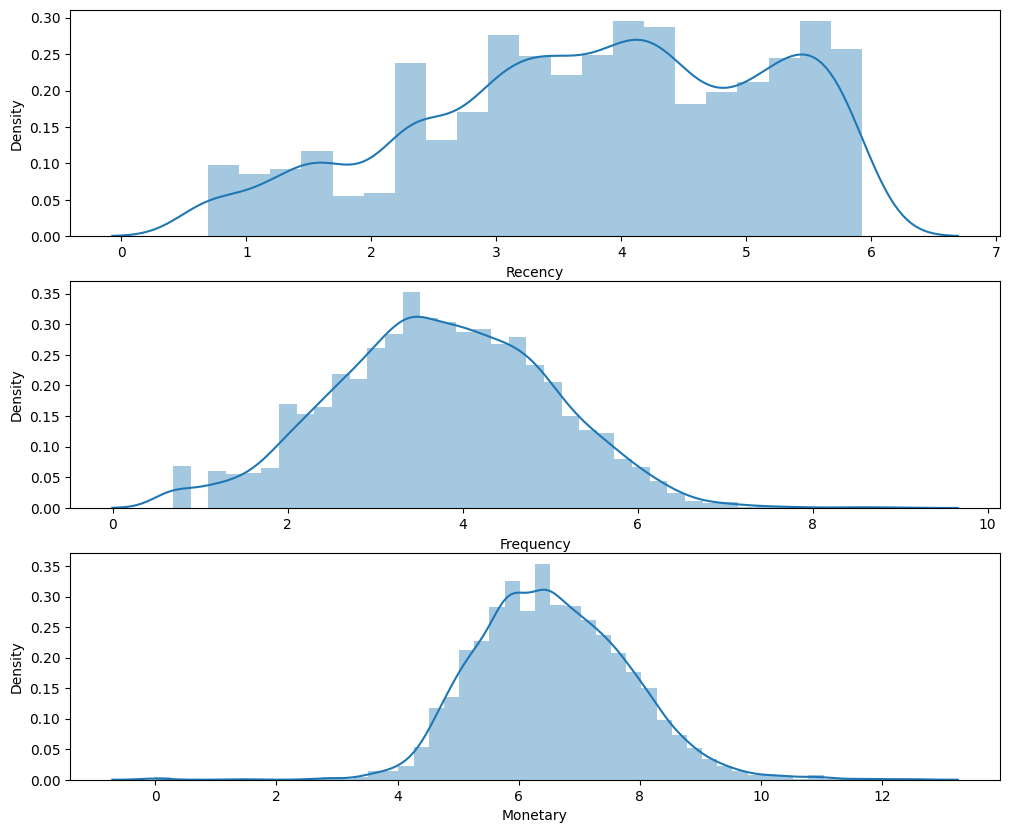

In [18]:
# Plot RFM distributions
plt.figure(figsize=(12,10))
# Plot distribution of R
plt.subplot(3, 1, 1); sns.distplot(df6['Recency'])
# Plot distribution of F
plt.subplot(3, 1, 2); sns.distplot(df6['Frequency'])
# Plot distribution of M
plt.subplot(3, 1, 3); sns.distplot(df6['Monetary'])
# Show the plot
plt.show()

It has made the data look more normal !

In [19]:
'''Do scaling to make sure all dimensions have equal mean and variance'''
scaler = StandardScaler() 
scaler.fit(df6)
df7 = pd.DataFrame(scaler.transform(df6))
df7.columns = df6.columns
df7.describe()

,Recency,Frequency,Monetary
count,4.322000e+03,4.322000e+03,4.322000e+03
mean,2.318059e-16,5.178643e-17,-1.315211e-17
std,1.000116e+00,1.000116e+00,1.000116e+00
min,-2.266647e+00,-2.479228e+00,-5.190991e+00
25%,-6.549258e-01,-6.596716e-01,-6.733421e-01
50%,1.017447e-01,4.572291e-04,-6.046579e-02
75%,8.444762e-01,6.985821e-01,6.594114e-01
max,1.572466e+00,4.205135e+00,4.732577e+00


# III. K-means clustering

## 1] K-means clustering from scratch (Without using library)

###### 'Clustering is the process of dividing the entire data into groups (also known as clusters) based on the patterns in the data'
###### Here we will group the data into three different groups so that the reatailer will find it easy to reach to the customers having similar interests instead of planning different strategies for indiviual customer. 
###### All the data points in a cluster should be similar to each other. All data points in different clusters must be very different from each other. If the customers in a particular cluster are not similar to each other, then their requirements might vary. Having similar data points within the same cluster helps the retailer to use targeted marketing.

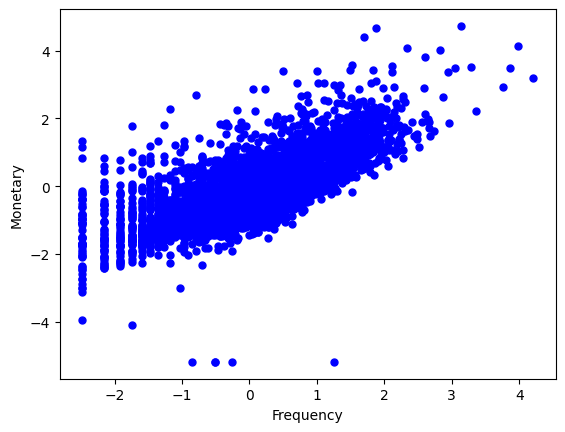

In [20]:
#Visualise data points
plt.scatter(df7["Frequency"],df7["Monetary"],c='blue',s=25)
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.show()

### Goal:  To minimize the sum of distances between the points and their respective cluster centroid

#### Steps:
1] Choose the number of clusters k
2] Select k random points from the data as centroids
3] Assign all the points to the closest cluster centroid
4] Recompute the centroids of newly formed clusters
5] Repeat steps 3 and 4
#### When to stop:
1] Centroids of newly formed clusters do not change
2] Points remain in the same cluster
3] Maximum number of iterations are reached

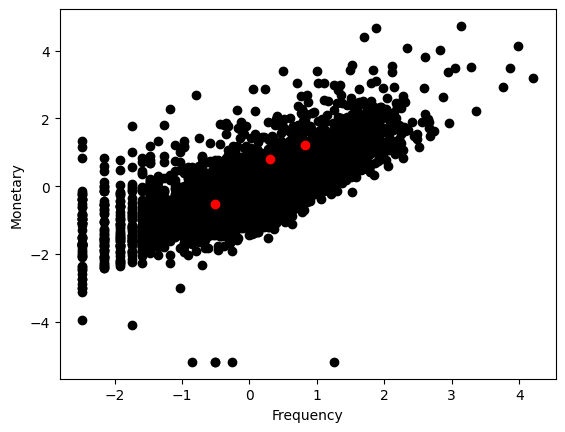

In [21]:
# Step 1 and 2 - Choose the number of clusters (k) and select random centroid for each cluster

#number of clusters
K=3

# Select random observation as centroids
Centroids = (df7.sample(n=K))
plt.scatter(df7["Frequency"],df7["Monetary"],c='black')
plt.scatter(Centroids["Frequency"],Centroids["Monetary"],c='red')
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.show()

In [22]:
# Step 3 - Assign all the points to the closest cluster centroid
# Step 4 - Recompute centroids of newly formed clusters
# Step 5 - Repeat step 3 and 4

diff = 1
j=0

while(diff!=0):
    XD=df7
    i=1
    for index1,row_c in Centroids.iterrows():
        ED=[]
        for index2,row_d in XD.iterrows():
            d1=(row_c["Recency"]-row_d["Recency"])**2
            d2=(row_c["Frequency"]-row_d["Frequency"])**2
            d3=(row_c["Monetary"]-row_d["Monetary"])**2
            d=np.sqrt(d1+d2+d3)
            ED.append(d)
        df7[i]=ED
        i=i+1

    C=[]
    for index,row in df7.iterrows():
        min_dist=row[1]
        pos=1
        for i in range(K):
            if row[i+1] < min_dist:
                min_dist = row[i+1]
                pos=i+1
        C.append(pos)
    df7["Cluster"]=C
    Centroids_new = df7.groupby(["Cluster"]).mean()[["Recency","Frequency","Monetary"]]
    if j == 0:
        diff=1
        j=j+1
    else:
        diff = (Centroids_new['Recency'] - Centroids['Recency']).sum()
        + (Centroids_new['Frequency'] - Centroids['Frequency']).sum() 
        + (Centroids_new['Monetary'] - Centroids['Monetary']).sum()
        print(diff.sum())
    Centroids = df7.groupby(["Cluster"]).mean()[["Recency","Frequency","Monetary"]]

0.06566428571318131
0.051402380799259906
0.04500779698588149
0.020607676998680838
0.06122366202537156
0.06318826445344572
0.03391596759946783
0.05345659880225474
0.04091095801727033
0.03183937579168403
0.028908758298466928
0.02534284173038706
0.010732616165944384
0.008182874812013748
0.003057747630351236
0.003923275950374491
0.0013349033230567811
0.0


##### The above values give the difference between the centroids in the previous iteration and the current iteration.
##### When this difference is 0, we are stopping the training.

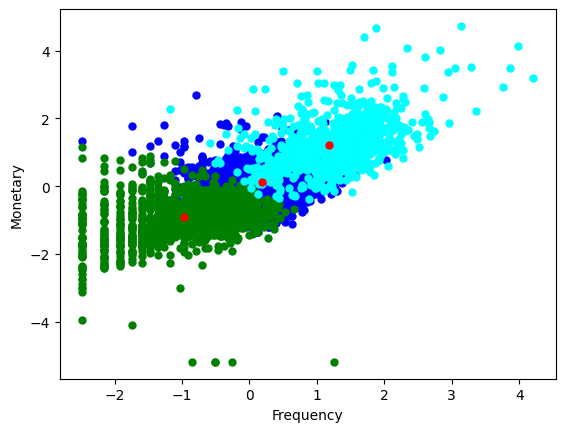

In [23]:
# visualizing the clusters formed after training
color=['blue','green','cyan']
for k in range(K):
    data1=df7[df7["Cluster"]==k+1]
    plt.scatter(data1["Frequency"],data1["Monetary"],c=color[k],s=25)
plt.scatter(Centroids["Frequency"],Centroids["Monetary"],c='red',s=25)
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.show()

### We can clearly see thre are three different clusters formed and their centroid is marked in red.

## 2] K-means clustering using python library

In [24]:
k_means = KMeans(n_clusters=2, random_state=1)

In [26]:
'''Let's see how this works:
Apply k-means on the preprocessed data and get cluster labels for each row'''

# k_means.fit(df7)
# clus_labels = k_means.labels_

 # Convert all column names to strings
df7.columns = df7.columns.astype(str)

# Now, you can fit your K-means model
k_means.fit(df7)

# Get cluster labels
clus_labels = k_means.labels_


In [27]:
'''Get cluster characteristics. Since we are interested in the original values,
we use the non-log transformed, non-standardized dataframe'''

df5_clus2 = df5.assign(Cluster = clus_labels)
print(df5_clus2.shape)
df5_clus2.head(2)

(4322, 4)


,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
12347.0,2,182,4310.00,0
12348.0,75,31,1797.24,1


In [28]:
df5_clus2.groupby(['Cluster']).agg({ 'Recency': 'mean',
'Frequency': 'mean',
'Monetary': ['mean', 'count'],
}).round(0)

Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0          25.0     191.0   4111.0  1712
1         133.0      28.0    481.0  2610

''' To determine the optimal value of K? There are at least two ways to find the optimal number of clusters: 
(1) Elbow plot and, (2) Silhoutte plot'''

In [29]:
'''1. Elbow method'''

# Fit KMeans and calculate SSE for each *k*
ss_error = {}
for k in range(1, 20):
    k_means = KMeans(n_clusters=k, random_state=1)
    k_means.fit(df7)
    ss_error[k] = k_means.inertia_

<Axes: title={'center': 'Elbow plot'}, xlabel='Value of k', ylabel='Sum of squared error'>

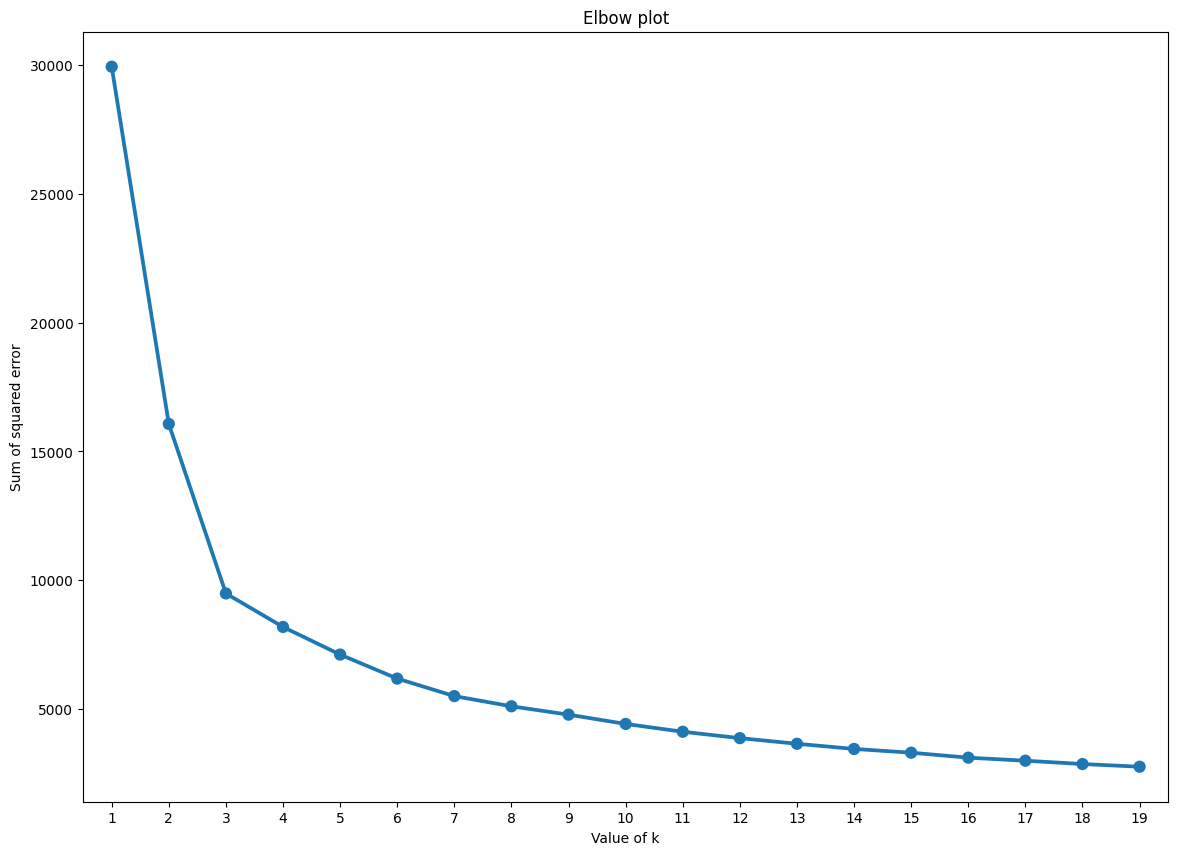

In [30]:
# Make elbow plot
plt.figure(figsize = (14,10))
plt.title('Elbow plot')
plt.xlabel('Value of k')
plt.ylabel('Sum of squared error')
sns.pointplot(x=list(ss_error.keys()), y=list(ss_error.values()))

For n_clusters = 2 The average silhouette_score is : 0.40840572493956256
For n_clusters = 3 The average silhouette_score is : 0.44509293097253877
For n_clusters = 4 The average silhouette_score is : 0.38537319012607124
For n_clusters = 5 The average silhouette_score is : 0.35854080767534535
For n_clusters = 6 The average silhouette_score is : 0.3179068608597688
For n_clusters = 7 The average silhouette_score is : 0.3310386087907855
For n_clusters = 8 The average silhouette_score is : 0.315921395215544
For n_clusters = 10 The average silhouette_score is : 0.3018689234558662
For n_clusters = 12 The average silhouette_score is : 0.3022961641941844
For n_clusters = 14 The average silhouette_score is : 0.2966138553678694


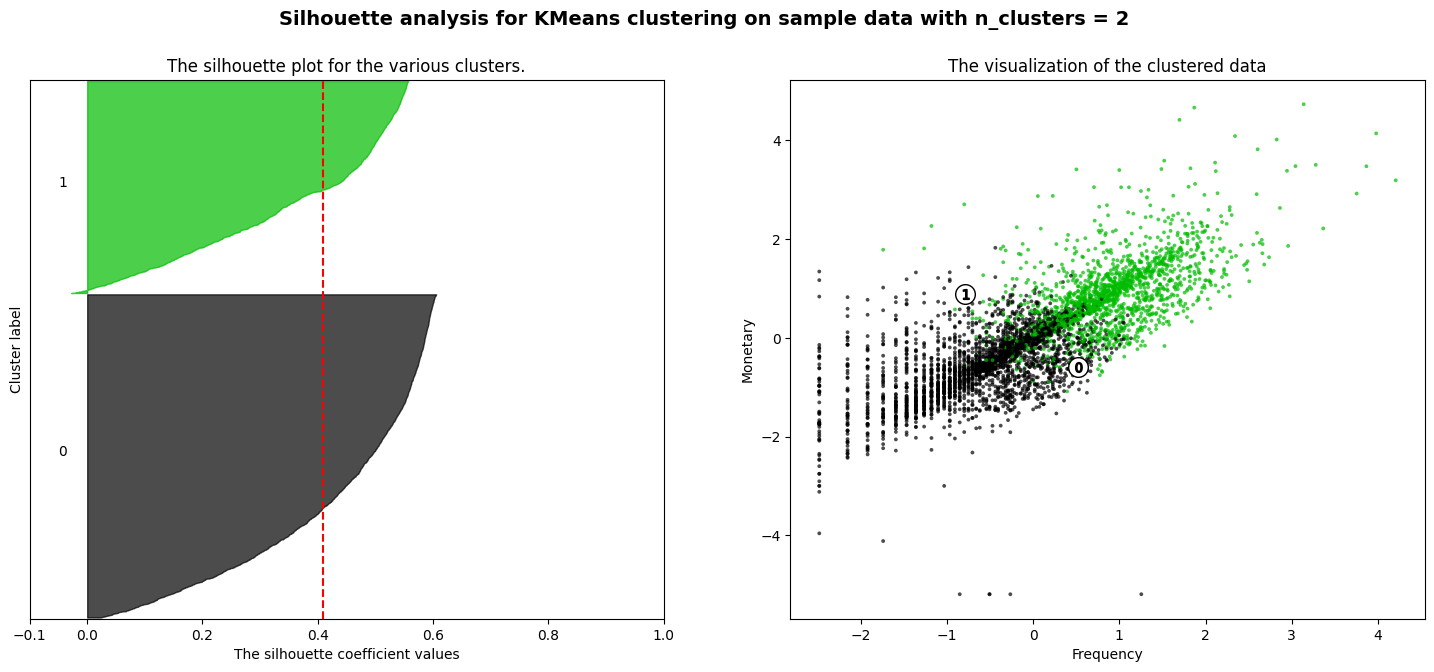

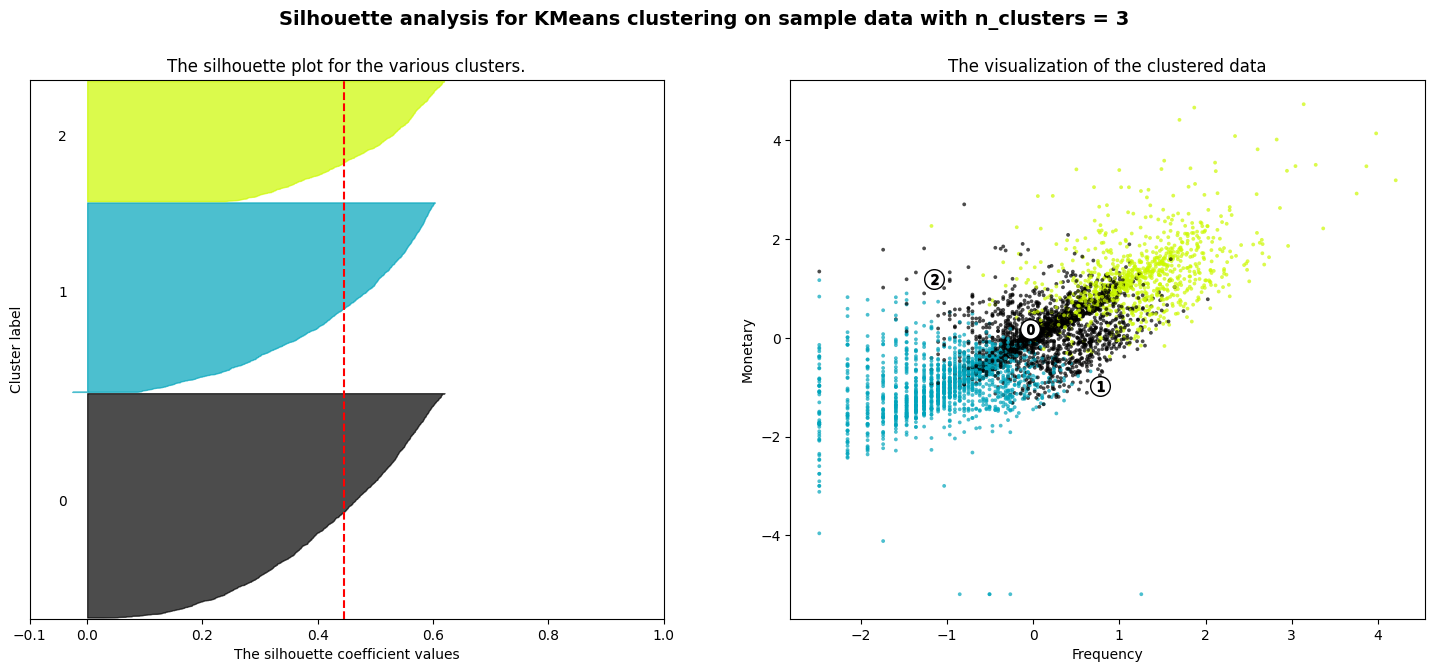

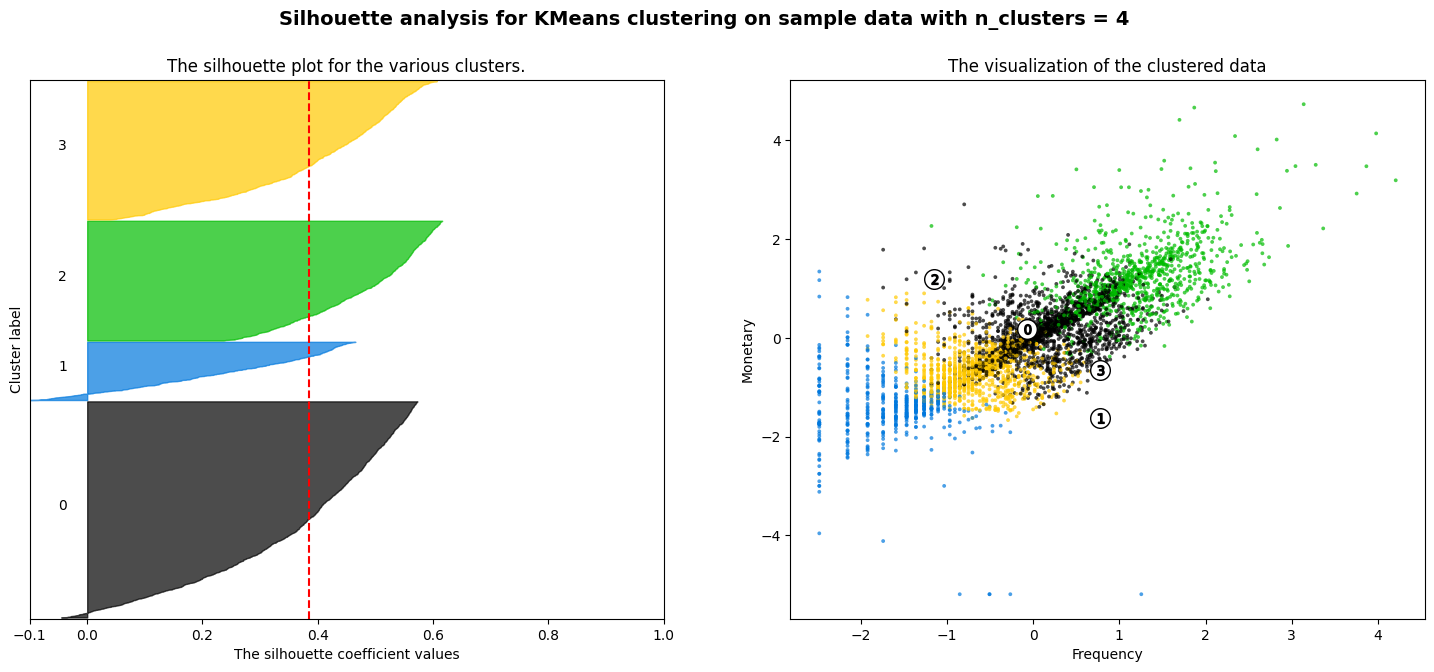

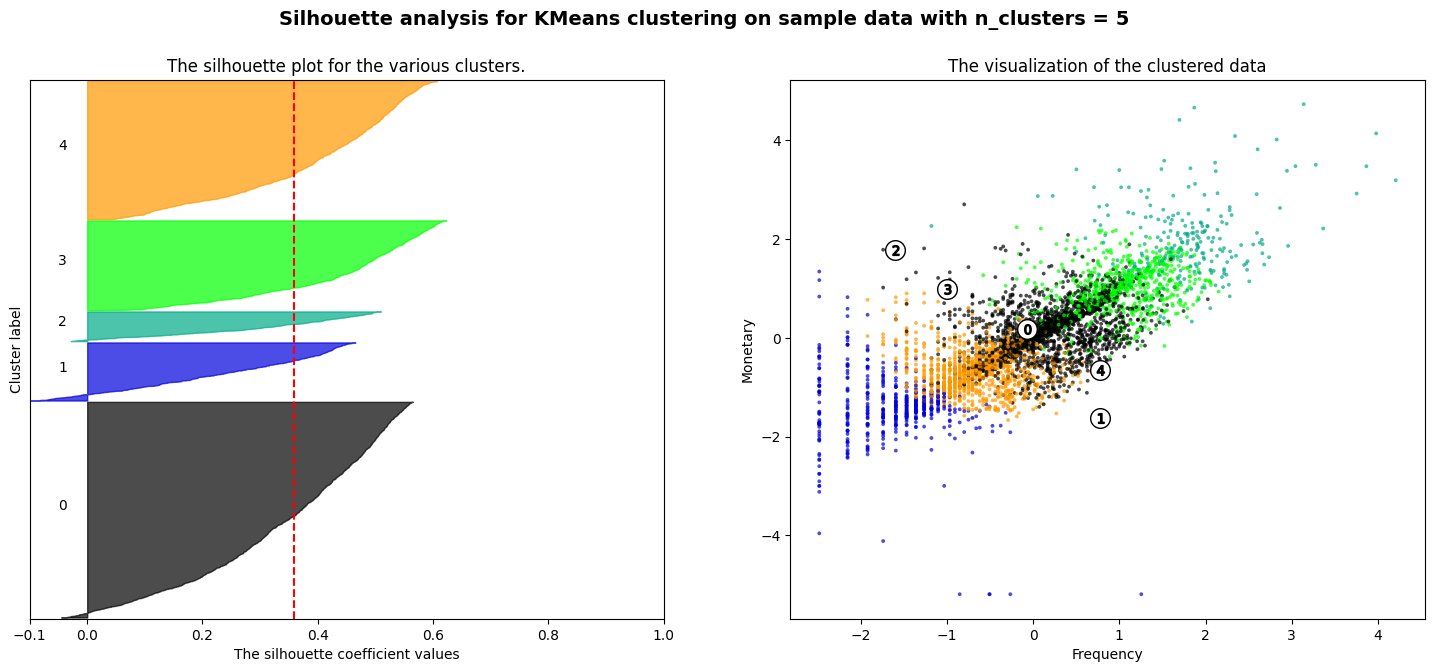

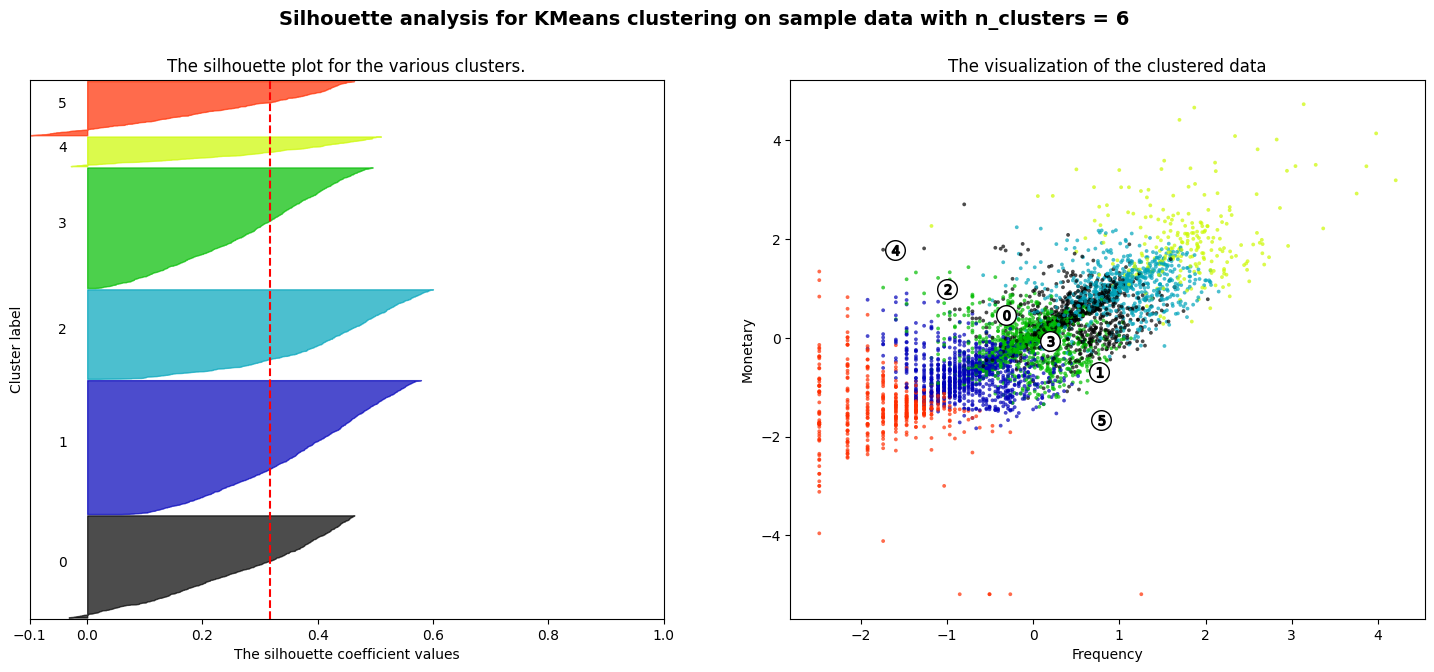

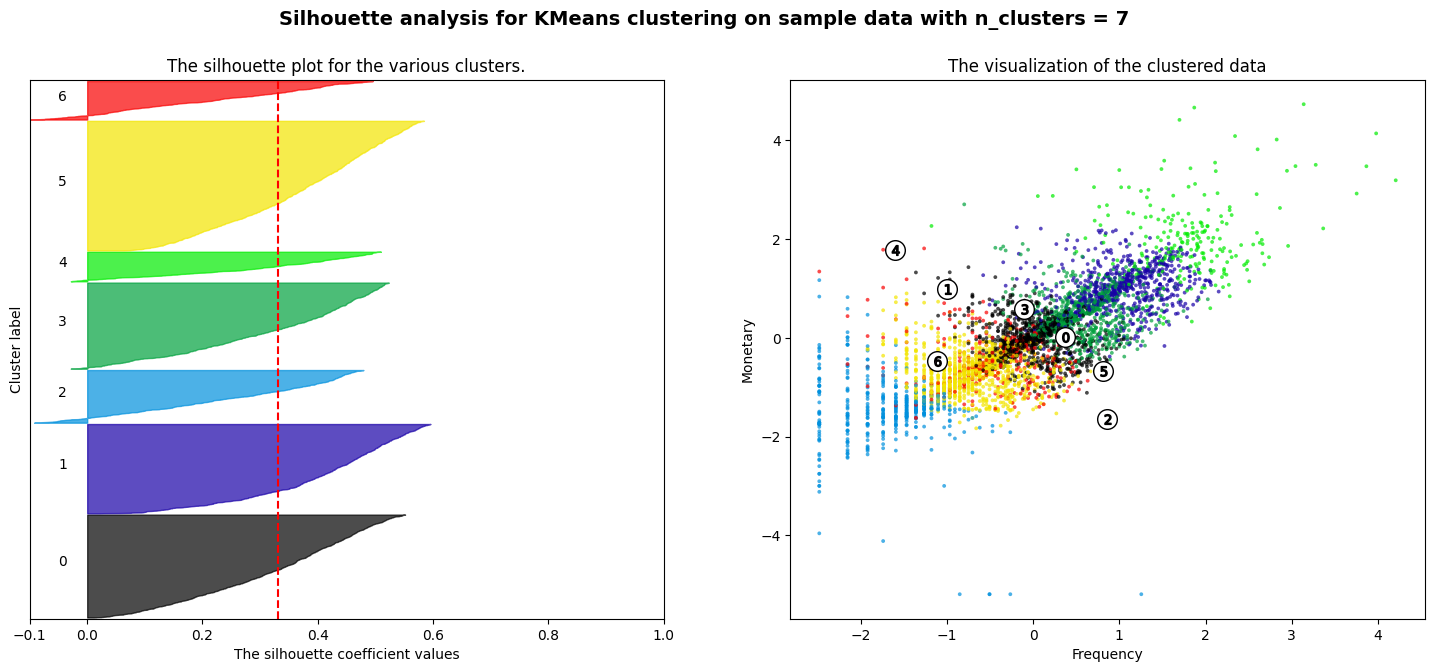

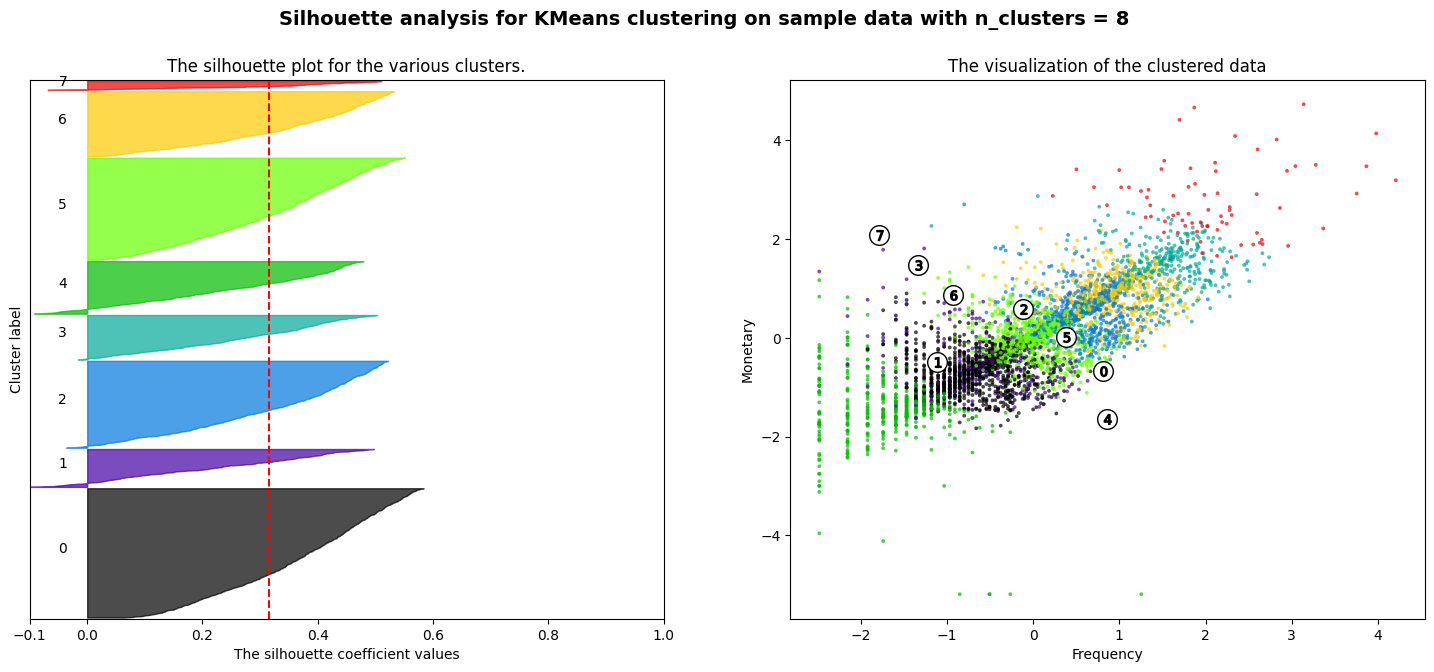

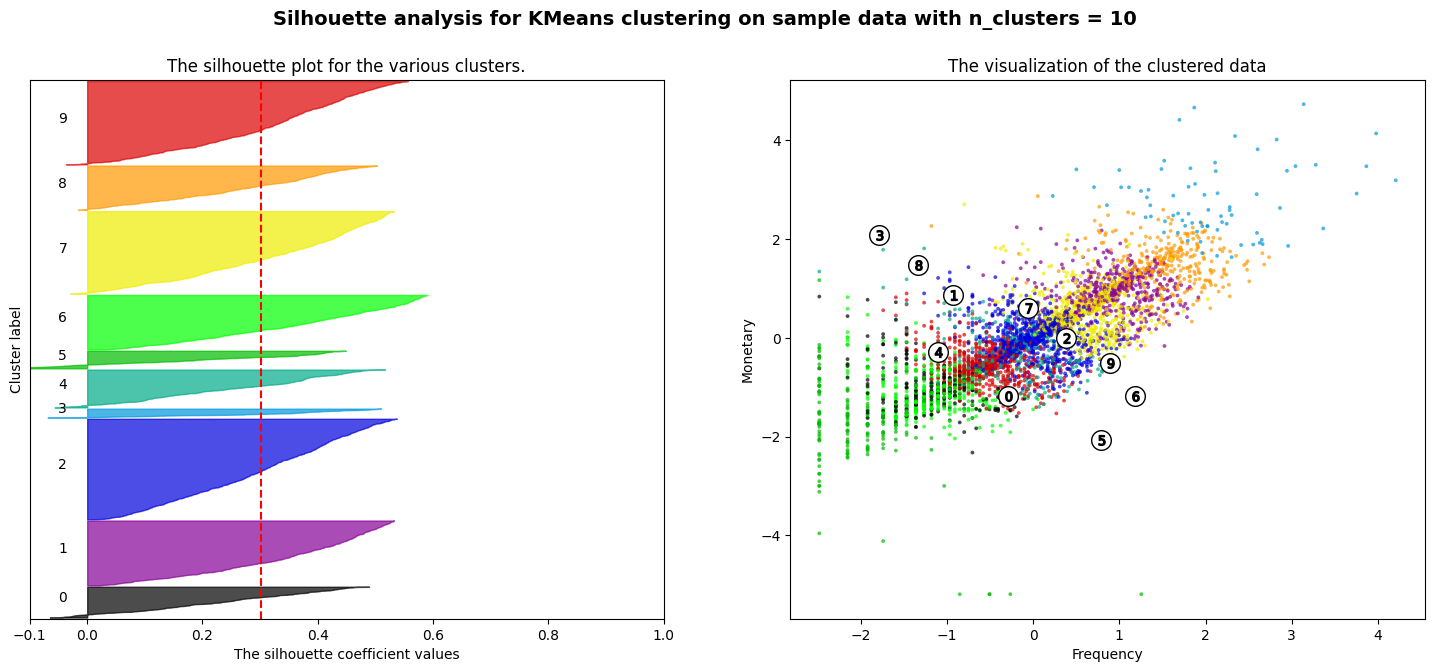

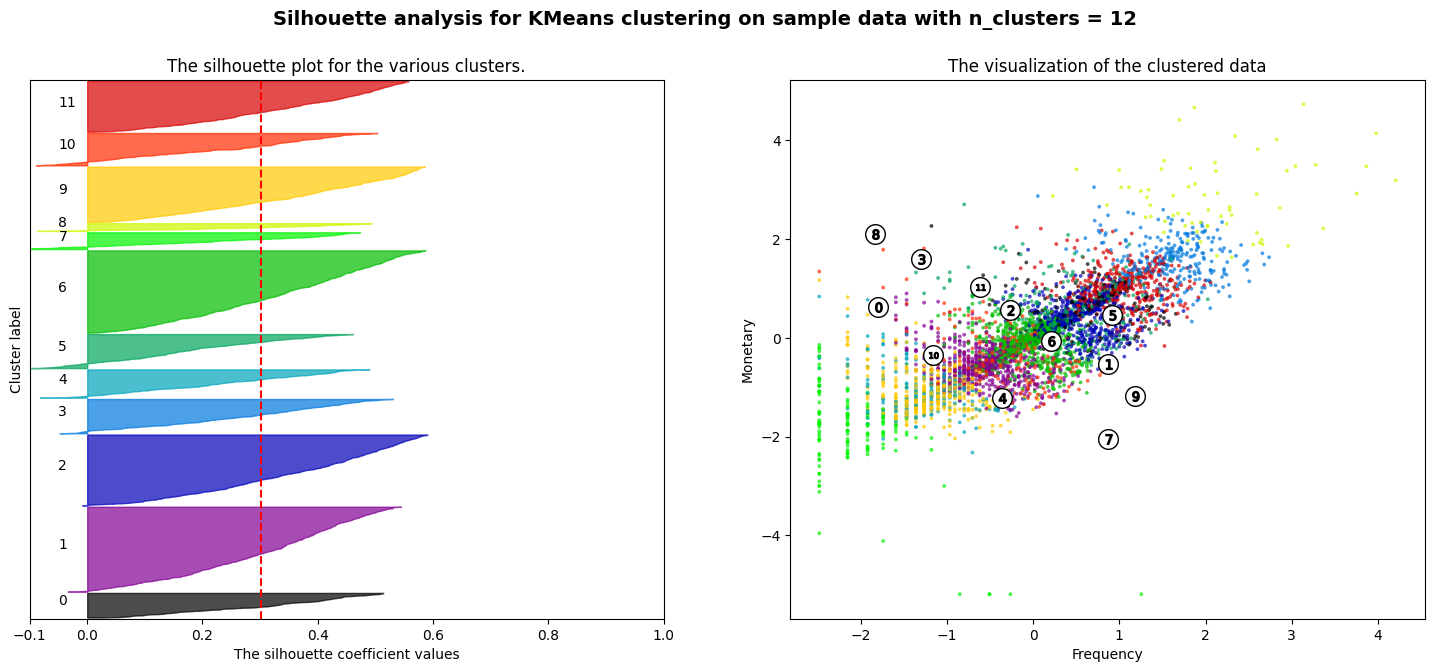

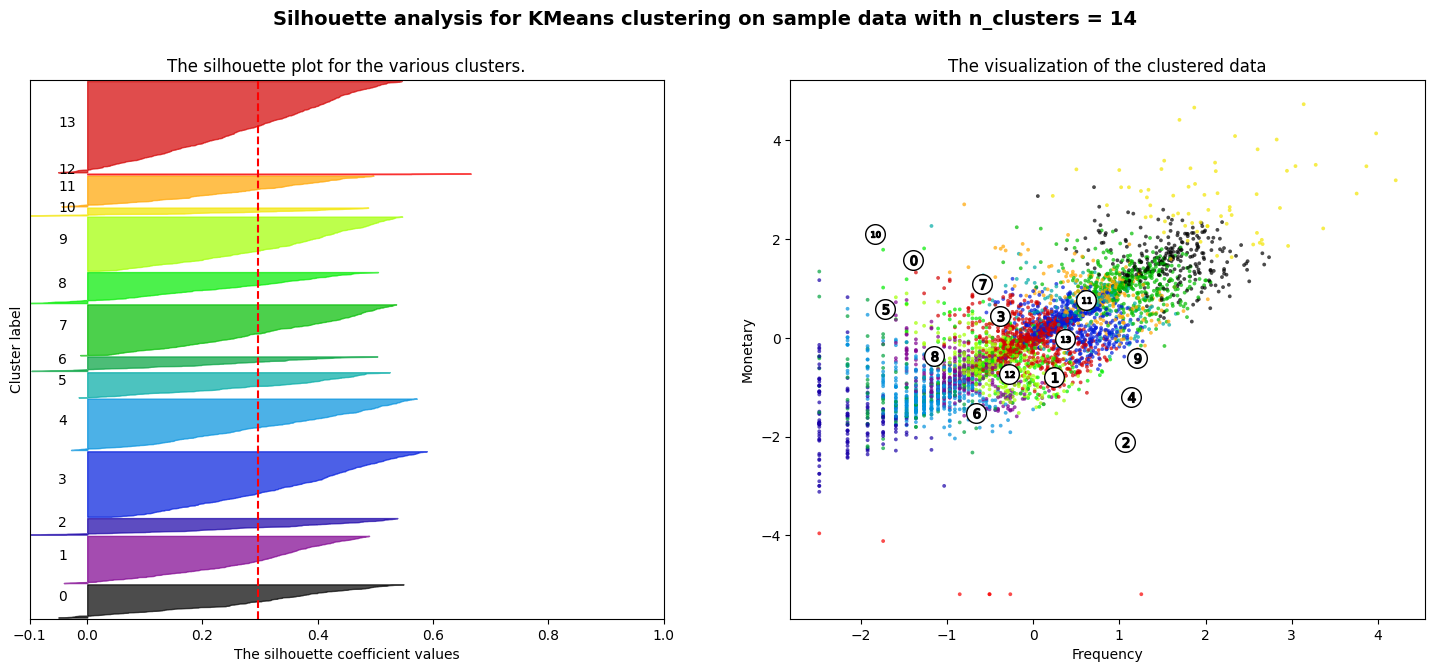

In [31]:
'''2. Solhouttte method.
Looks like k = 2 is a good solution. But always, explore other values of K around the elbow.
Finally disucss several solutions with stakeholders to see which makes most sense !
Here, we also use Silhoutte plots and scores'''

# Number of clusters confirmation by silhoutte scores
X = df7
range_n_clusters = [2, 3, 4, 5, 6,7,8,10,12,14]
for n_clusters in range_n_clusters:
    global str
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10,)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, i)

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X["Frequency"], X["Monetary"], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data")
    ax2.set_xlabel("Frequency")
    ax2.set_ylabel("Monetary")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')



In [32]:
'''Looks like k = 2 has the best Silhoutte score. So let's pick k = 2 and do some interesting visualizations.
Add cluster column to the pre-processed data'''
df8 = df7.assign(Cluster = clus_labels)
print(df8.shape)
df8.head(3)

(4322, 7)


,Recency,Frequency,Monetary,1,2,3,Cluster
0,-1.969228,1.171002,1.431403,2.535649,4.190861,0.851864,0
1,0.401617,-0.238345,0.739514,0.867091,1.840877,2.155337,1
2,-0.577641,0.439216,0.721853,0.848496,2.541417,1.058367,0


In [33]:
'''Use melt to transform the dataframe (not the data itself)'''
df8_melt = pd.melt(df8.reset_index(), id_vars=['Cluster'],
value_vars=['Recency', 'Frequency', 'Monetary'], var_name='Attribute',
value_name='Value')

In [34]:
df8_melt.head(3)

,Cluster,Attribute,Value
0,0,Recency,-1.969228
1,1,Recency,0.401617
2,0,Recency,-0.577641


<Axes: title={'center': 'Segment plot'}, xlabel='Attribute', ylabel='Value'>

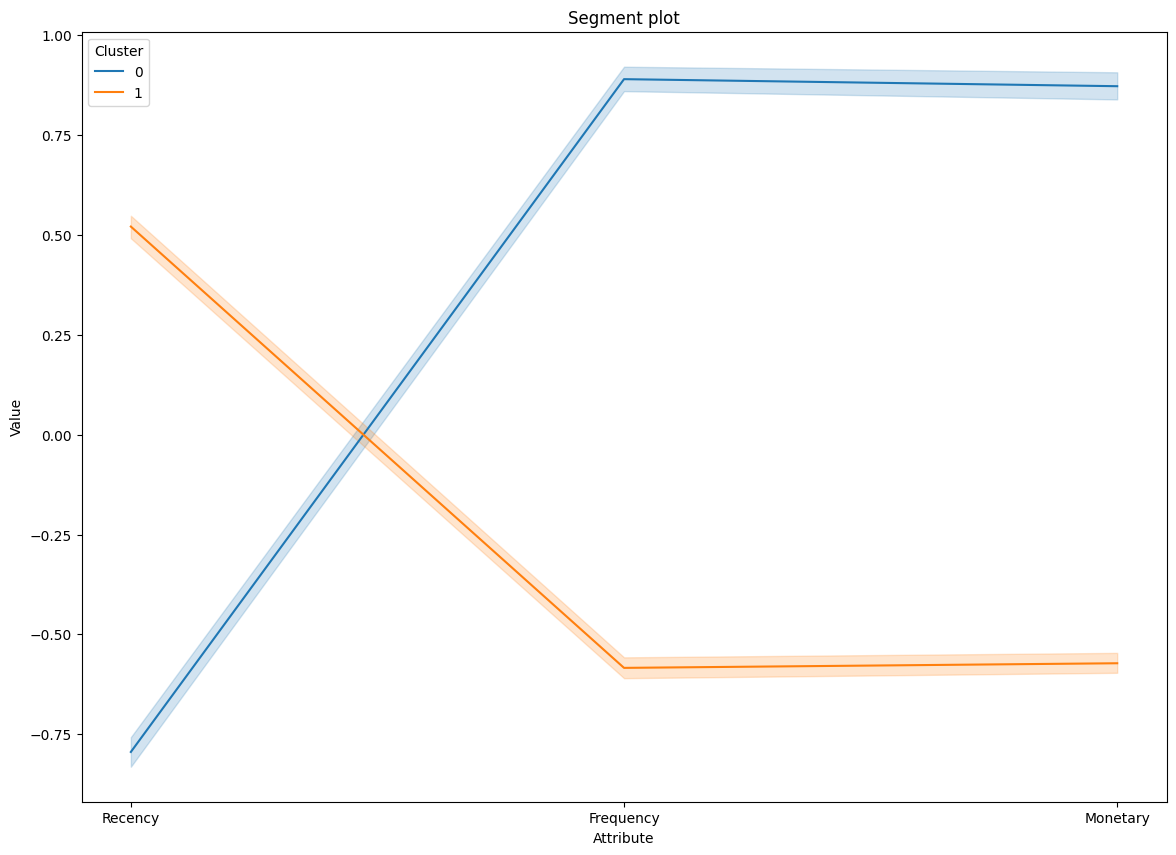

In [35]:
'''Visualize segment characteristics to understand the clusters better'''
plt.figure(figsize = (14,10))
plt.title('Segment plot') 
sns.lineplot(x="Attribute", y="Value", hue='Cluster', data=df8_melt)

# IV. Relative feature importances w.r.t clusters

In [36]:
cluster_avg = df5_clus2.groupby(['Cluster']).mean()
cluster_avg

,Recency,Frequency,Monetary
Cluster,,,
0,25.086449,191.064252,4110.503020
1,133.148276,28.428736,480.677162


In [37]:
population_avg = df5.mean()
population_avg

Recency        90.343591
Frequency      92.850764
Monetary     1918.498048
dtype: float64

In [38]:
relative_imp = cluster_avg / population_avg - 1

In [39]:
relative_imp.round(2)

,Recency,Frequency,Monetary
Cluster,,,
0,-0.72,1.06,1.14
1,0.47,-0.69,-0.75


<Axes: title={'center': 'Relative importance of attributes'}, ylabel='Cluster'>

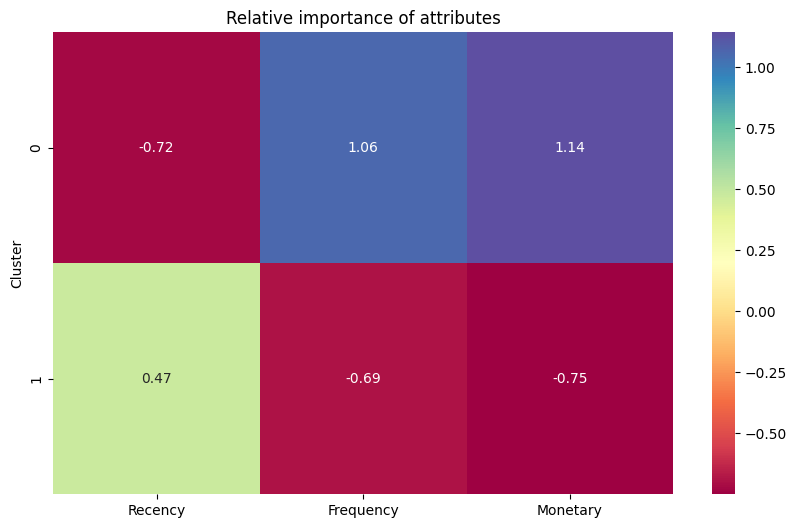

In [40]:
plt.figure(figsize=(10, 6))
plt.title('Relative importance of attributes') 
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='Spectral')